# ARIMA

In [ ]:
!pip install numpy==1.23.5  # Versión estable compatible
!pip install pmdarima==2.0.3

In [ ]:
import pandas as pd
df_estadistico = pd.read_csv('/content/df_estadistico.csv',
                 encoding='latin-1',
                 sep=',',
                 decimal='.')



In [ ]:
from collections import defaultdict

fechas_completas = pd.date_range(start='2014-01-01', end='2023-12-01', freq='MS')
n_total_meses = len(fechas_completas)

series_dict = {}
series_faltantes = {}
series_descartadas = {}

# Recalcular agrupado limpio
df_agrupado = df_estadistico.groupby(['Fecha', 'Grupo_Consumo', 'Latitud', 'Longitud'])['Energia_GWh'].sum().reset_index()

for key, grupo in df_agrupado.groupby(['Grupo_Consumo', 'Latitud', 'Longitud']):
    serie = grupo[['Fecha', 'Energia_GWh']].copy()
    serie['Fecha'] = pd.to_datetime(serie['Fecha'])
    serie = serie.drop_duplicates(subset='Fecha')
    serie = serie.set_index('Fecha').sort_index()
    serie = serie[~serie.index.duplicated(keep='first')]
    serie = serie.asfreq('MS')
    serie = serie.reindex(fechas_completas)

    # Detectar fechas faltantes originales
    fechas_faltantes = serie[serie['Energia_GWh'].isna()].index
    series_faltantes[key] = fechas_faltantes

    # 🔍 Analizar por año
    faltantes_por_anio = defaultdict(int)
    for fecha in fechas_faltantes:
        faltantes_por_anio[fecha.year] += 1

    # Contar cuántos años tienen > 2 meses faltantes
    años_invalidos = sum(1 for f in faltantes_por_anio.values() if f > 2)

    if años_invalidos > 2:
        series_descartadas[key] = fechas_faltantes
        continue  # ❌ Descartar esta serie

    # ✅ Mantener: interpolar
    serie = serie.interpolate(method='linear')
    serie = serie.fillna(0)
    series_dict[key] = serie


In [ ]:
print(f"🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: {len(series_descartadas)}")
for i, (clave, fechas) in enumerate(series_descartadas.items()):
    grupo, lat, lon = clave
    print(f"{i+1}. {grupo} - ({lat}, {lon}) → {len(fechas)} fechas faltantes")
    if i >= 4: break


🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: 1
1. Alumbrado PÃºblico - (0.5022, -77.8857) → 59 fechas faltantes


In [ ]:
n_total_series = len(series_dict) + len(series_descartadas)

print("📊 RESUMEN DE PROCESAMIENTO DE SERIES")
print("──────────────────────────────────────────")
print(f"🔢 Total de series analizadas:     {n_total_series}")
print(f"✅ Series conservadas (interpoladas): {len(series_dict)}")
print(f"❌ Series descartadas (>2 años incompletos): {len(series_descartadas)}")
print("──────────────────────────────────────────")


📊 RESUMEN DE PROCESAMIENTO DE SERIES
──────────────────────────────────────────
🔢 Total de series analizadas:     116
✅ Series conservadas (interpoladas): 115
❌ Series descartadas (>2 años incompletos): 1
──────────────────────────────────────────


In [ ]:
from pmdarima import auto_arima

def obtener_parametros_arima(serie):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    y = serie['Energia_GWh']

    modelo = auto_arima(y,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore")

    orden = modelo.order
    print(f"→ ARIMA{orden}")
    return orden


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

parametros_por_serie = {}

for clave, serie in series_dict.items():

    try:
        print(f"📈 Analizando {clave}")
        orden = obtener_parametros_arima(serie)
        parametros_por_serie[clave] = orden
    except Exception as e:
        print(f"❌ Error en {clave}: {e}")


📈 Analizando ('Alumbrado PÃºblico', -3.9931, -79.2042)
→ ARIMA(1, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -3.2596, -79.9585)
→ ARIMA(0, 1, 3)
📈 Analizando ('Alumbrado PÃºblico', -2.9006, -79.0045)
→ ARIMA(0, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -2.5489, -78.9382)
→ ARIMA(1, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -2.2301, -80.8599)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -2.1709, -79.9224)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -1.7946, -79.5342)
→ ARIMA(1, 0, 2)
📈 Analizando ('Alumbrado PÃºblico', -1.6708, -78.6569)
→ ARIMA(0, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -1.6167, -79.0)
→ ARIMA(1, 1, 0)
📈 Analizando ('Alumbrado PÃºblico', -1.2543, -78.622)
→ ARIMA(0, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -0.9676, -80.7089)
→ ARIMA(1, 1, 0)
📈 Analizando ('Alumbrado PÃºblico', -0.9538, -90.9656)
→ ARIMA(1, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.9381, -78.614)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.6743, -76.9864)
→ ARIMA(0, 1, 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def ajustar_y_predecir_arima(serie, orden):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    # Cortar por fecha explícita
    train = serie.loc[:'2022-12-01']
    test = serie.loc['2023-01-01':'2023-12-01']

    modelo = ARIMA(train, order=orden)
    resultado = modelo.fit()

    pred = resultado.forecast(steps=len(test))
    fechas = test.index

    df_pred = pd.DataFrame({
        'Fecha': fechas,
        'Prediccion_GWh': pred.values,
        'Real_GWh': test['Energia_GWh'].values
    })

    # Métricas
    denominador = test['Energia_GWh'].replace(0, np.nan)
    mae = mean_absolute_error(test['Energia_GWh'], pred)
    rmse = np.sqrt(mean_squared_error(test['Energia_GWh'], pred))
    mape = np.mean(np.abs((test['Energia_GWh'] - pred) / denominador)) * 100

    print(f"ARIMA{orden} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")
    return df_pred

In [ ]:
todas_las_predicciones = []
warnings.filterwarnings("ignore", category=FutureWarning)
for clave, serie in series_dict.items():
    if clave in parametros_por_serie:
        orden = parametros_por_serie[clave]
        grupo, lat, lon = clave
        try:
            print(f"🔁 Procesando {grupo} - ({lat}, {lon}) con ARIMA{orden}")
            df_pred = ajustar_y_predecir_arima(serie, orden=orden)
            df_pred['Grupo_Consumo'] = grupo
            df_pred['Latitud'] = lat
            df_pred['Longitud'] = lon
            todas_las_predicciones.append(df_pred)
        except Exception as e:
            print(f"❌ Error en {clave}: {e}")

if 'todas_las_predicciones' in locals():
    df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)
else:
    print("❌ La variable 'todas_las_predicciones' no está definida.")


🔁 Procesando Alumbrado PÃºblico - (-3.9931, -79.2042) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.2201 | RMSE: 0.2886 | MAPE: 5.07%
🔁 Procesando Alumbrado PÃºblico - (-3.2596, -79.9585) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 9.3006 | RMSE: 18.0726 | MAPE: 28.69%
🔁 Procesando Alumbrado PÃºblico - (-2.9006, -79.0045) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.3702 | RMSE: 0.4216 | MAPE: 3.07%
🔁 Procesando Alumbrado PÃºblico - (-2.5489, -78.9382) con ARIMA(1, 1, 2)
ARIMA(1, 1, 2) | MAE: 0.0332 | RMSE: 0.0414 | MAPE: 2.58%
🔁 Procesando Alumbrado PÃºblico - (-2.2301, -80.8599) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.4658 | RMSE: 0.9596 | MAPE: 6.23%
🔁 Procesando Alumbrado PÃºblico - (-2.1709, -79.9224) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.9379 | RMSE: 1.3148 | MAPE: 3.48%
🔁 Procesando Alumbrado PÃºblico - (-1.7946, -79.5342) con ARIMA(1, 0, 2)
ARIMA(1, 0, 2) | MAE: 0.2645 | RMSE: 0.3793 | MAPE: 7.86%
🔁 Procesando Alumbrado PÃºblico - (-1.6708, -78.6569) con ARIMA(0, 1, 2)
ARIMA(0,

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0) | MAE: 0.1116 | RMSE: 0.1247 | MAPE: 6.68%
🔁 Procesando Alumbrado PÃºblico - (-1.2543, -78.622) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.9249 | RMSE: 1.2722 | MAPE: 9.94%
🔁 Procesando Alumbrado PÃºblico - (-0.9676, -80.7089) con ARIMA(1, 1, 0)
ARIMA(1, 1, 0) | MAE: 0.3285 | RMSE: 0.3560 | MAPE: 2.43%
🔁 Procesando Alumbrado PÃºblico - (-0.9538, -90.9656) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.0133 | RMSE: 0.0138 | MAPE: 4.75%
🔁 Procesando Alumbrado PÃºblico - (-0.9381, -78.614) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.1820 | RMSE: 0.1981 | MAPE: 5.09%
🔁 Procesando Alumbrado PÃºblico - (-0.6743, -76.9864) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 0.0339 | RMSE: 0.0472 | MAPE: 2.67%
🔁 Procesando Alumbrado PÃºblico - (-0.2511, -79.1717) con ARIMA(1, 1, 0)
ARIMA(1, 1, 0) | MAE: 0.6874 | RMSE: 1.4966 | MAPE: 159.18%
🔁 Procesando Alumbrado PÃºblico - (-0.2295, -78.5243) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.8588 | RMSE: 1.4029 | MAPE: 4.03%
🔁 Procesando Alumbrado PÃ

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) | MAE: 2.8822 | RMSE: 3.1479 | MAPE: 37.91%
🔁 Procesando Alumbrado PÃºblico - (0.9682, -79.6517) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.1383 | RMSE: 0.1694 | MAPE: 3.24%
🔁 Procesando Comercial - (-4.0655, -78.9542) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.1352 | RMSE: 0.1579 | MAPE: 8.83%
🔁 Procesando Comercial - (-3.9931, -79.2042) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.3210 | RMSE: 0.3617 | MAPE: 5.85%
🔁 Procesando Comercial - (-3.2596, -79.9585) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 1.1203 | RMSE: 1.2718 | MAPE: 6.95%
🔁 Procesando Comercial - (-2.9006, -79.0045) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.6315 | RMSE: 0.7268 | MAPE: 4.65%
🔁 Procesando Comercial - (-2.5489, -78.9382) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.4841 | RMSE: 0.5320 | MAPE: 14.33%
🔁 Procesando Comercial - (-2.393, -78.1105) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 0.1181 | RMSE: 0.1385 | MAPE: 6.54%
🔁 Procesando Comercial - (-2.2301, -80.8599) con ARIMA(3, 0, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) | MAE: 1.0502 | RMSE: 1.1529 | MAPE: 13.55%
🔁 Procesando Comercial - (-2.1709, -79.9224) con ARIMA(1, 0, 0)
ARIMA(1, 0, 0) | MAE: 13.7488 | RMSE: 14.6305 | MAPE: 9.61%
🔁 Procesando Comercial - (-1.7946, -79.5342) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 1.1512 | RMSE: 1.3047 | MAPE: 8.59%
🔁 Procesando Comercial - (-1.6708, -78.6569) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.3236 | RMSE: 0.3624 | MAPE: 5.51%
🔁 Procesando Comercial - (-1.6167, -79.0) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.0738 | RMSE: 0.0844 | MAPE: 5.47%
🔁 Procesando Comercial - (-1.491, -77.9916) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.0908 | RMSE: 0.1168 | MAPE: 5.80%
🔁 Procesando Comercial - (-1.2543, -78.622) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.2747 | RMSE: 0.4179 | MAPE: 3.44%
🔁 Procesando Comercial - (-1.0515, -77.732) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.1906 | RMSE: 0.2065 | MAPE: 10.41%
🔁 Procesando Comercial - (-0.9676, -80.7089) con ARIMA(1, 1, 0)
ARIMA(1, 1, 0) | MAE: 4.15

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 1) | MAE: 0.3245 | RMSE: 0.3838 | MAPE: 5.54%
🔁 Procesando Industrial - (-4.0655, -78.9542) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 6.7649 | RMSE: 7.5363 | MAPE: 11.57%
🔁 Procesando Industrial - (-3.9931, -79.2042) con ARIMA(2, 1, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) | MAE: 0.1221 | RMSE: 0.1516 | MAPE: 12.00%
🔁 Procesando Industrial - (-3.2596, -79.9585) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 1.6516 | RMSE: 1.8573 | MAPE: 7.01%
🔁 Procesando Industrial - (-2.9006, -79.0045) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 1.7601 | RMSE: 2.8845 | MAPE: 6.21%
🔁 Procesando Industrial - (-2.5489, -78.9382) con ARIMA(1, 1, 0)
ARIMA(1, 1, 0) | MAE: 0.4237 | RMSE: 0.5182 | MAPE: 12.23%
🔁 Procesando Industrial - (-2.393, -78.1105) con ARIMA(1, 0, 2)
ARIMA(1, 0, 2) | MAE: 0.0105 | RMSE: 0.0153 | MAPE: 5.75%
🔁 Procesando Industrial - (-2.2301, -80.8599) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.3406 | RMSE: 0.4724 | MAPE: 5.91%
🔁 Procesando Industrial - (-2.1709, -79.9224) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 8.6095 | RMSE: 10.6774 | MAPE: 4.45%
🔁 Procesando Industrial - (-1.7946, -79.5342) con ARIMA(3, 0, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3) | MAE: 0.6093 | RMSE: 0.7707 | MAPE: 8.32%
🔁 Procesando Industrial - (-1.6708, -78.6569) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 8.0228 | RMSE: 9.1200 | MAPE: 237.06%
🔁 Procesando Industrial - (-1.6167, -79.0) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.0061 | RMSE: 0.0076 | MAPE: 11.31%
🔁 Procesando Industrial - (-1.491, -77.9916) con ARIMA(2, 0, 0)
ARIMA(2, 0, 0) | MAE: 0.0369 | RMSE: 0.0409 | MAPE: 7.72%
🔁 Procesando Industrial - (-1.2543, -78.622) con ARIMA(1, 0, 0)
ARIMA(1, 0, 0) | MAE: 0.6158 | RMSE: 0.7313 | MAPE: 5.82%
🔁 Procesando Industrial - (-1.0515, -77.732) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.0702 | RMSE: 0.0867 | MAPE: 4.84%
🔁 Procesando Industrial - (-0.9676, -80.7089) con ARIMA(3, 0, 0)
ARIMA(3, 0, 0) | MAE: 4.3226 | RMSE: 4.5249 | MAPE: 16.52%
🔁 Procesando Industrial - (-0.9538, -90.9656) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 0.0054 | RMSE: 0.0066 | MAPE: 8.24%
🔁 Procesando Industrial - (-0.9381, -78.614) con ARIMA(1, 0, 0)
ARIMA(1, 0, 0) | MA

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) | MAE: 0.0401 | RMSE: 0.0731 | MAPE: 4.37%
🔁 Procesando Otros - (-1.2543, -78.622) con ARIMA(0, 0, 0)
ARIMA(0, 0, 0) | MAE: 0.1421 | RMSE: 0.1625 | MAPE: 3.33%
🔁 Procesando Otros - (-1.0515, -77.732) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.1769 | RMSE: 0.1873 | MAPE: 15.12%
🔁 Procesando Otros - (-0.9676, -80.7089) con ARIMA(2, 1, 3)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 3) | MAE: 3.3812 | RMSE: 3.4996 | MAPE: 12.98%
🔁 Procesando Otros - (-0.9538, -90.9656) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 0.3239 | RMSE: 0.3342 | MAPE: 38.00%
🔁 Procesando Otros - (-0.9381, -78.614) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.5741 | RMSE: 0.9389 | MAPE: 72.89%
🔁 Procesando Otros - (-0.6743, -76.9864) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.0815 | RMSE: 0.1104 | MAPE: 4.04%
🔁 Procesando Otros - (-0.2511, -79.1717) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.1663 | RMSE: 0.2023 | MAPE: 3.45%
🔁 Procesando Otros - (-0.2295, -78.5243) con ARIMA(3, 0, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 0, 2) | MAE: 38.5921 | RMSE: 42.9610 | MAPE: 128.28%
🔁 Procesando Otros - (0.087, -76.8881) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.1401 | RMSE: 0.1984 | MAPE: 5.05%
🔁 Procesando Otros - (0.3517, -78.1223) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.2166 | RMSE: 0.3926 | MAPE: 12.55%
🔁 Procesando Otros - (0.5022, -77.8857) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.0756 | RMSE: 0.0938 | MAPE: 13.62%
🔁 Procesando Otros - (0.9682, -79.6517) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.3674 | RMSE: 0.4696 | MAPE: 4.95%
🔁 Procesando Residencial - (-4.0655, -78.9542) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 0.1600 | RMSE: 0.1967 | MAPE: 5.09%
🔁 Procesando Residencial - (-3.9931, -79.2042) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.6280 | RMSE: 0.7615 | MAPE: 4.40%
🔁 Procesando Residencial - (-3.2596, -79.9585) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 5.7619 | RMSE: 10.2719 | MAPE: 8.69%
🔁 Procesando Residencial - (-2.9006, -79.0045) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.9543 |

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) | MAE: 38.5866 | RMSE: 41.8509 | MAPE: 15.62%
🔁 Procesando Residencial - (-1.7946, -79.5342) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 1.3377 | RMSE: 1.5795 | MAPE: 3.88%
🔁 Procesando Residencial - (-1.6708, -78.6569) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 0.4072 | RMSE: 0.4804 | MAPE: 3.12%
🔁 Procesando Residencial - (-1.6167, -79.0) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.2092 | RMSE: 0.2202 | MAPE: 4.85%
🔁 Procesando Residencial - (-1.491, -77.9916) con ARIMA(0, 1, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 2) | MAE: 0.2516 | RMSE: 0.2896 | MAPE: 9.34%
🔁 Procesando Residencial - (-1.2543, -78.622) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 1.9051 | RMSE: 2.0501 | MAPE: 10.52%
🔁 Procesando Residencial - (-1.0515, -77.732) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.3218 | RMSE: 0.3525 | MAPE: 8.97%
🔁 Procesando Residencial - (-0.9676, -80.7089) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 4.5162 | RMSE: 5.5941 | MAPE: 6.40%
🔁 Procesando Residencial - (-0.9538, -90.9656) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 0.8539 | RMSE: 0.8865 | MAPE: 33.69%
🔁 Procesando Residencial - (-0.9381, -78.614) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.4709 | RMSE: 0.5604 | MAPE: 4.28%
🔁 Procesando Residencial - (-0.6743, -76.9864) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 0.5313 | RMSE: 0.6998 | MAPE: 8.50%
🔁 Procesando Residencial - (-0.2511, -79.1717) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 1.2027 | RMSE: 1.3308 | MAPE: 6.46%
🔁 Procesando Residencial - (-0.2295, -78.5243) con ARIMA(0, 1, 2)
ARIMA(0, 

In [ ]:
df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)

# Sumar todas las predicciones mensuales para obtener la curva nacional
df_nacional_predicho = df_total_pred.groupby('Fecha')['Prediccion_GWh'].sum().reset_index()


In [ ]:
# Calcular la curva nacional real (suma de todas las series por mes)
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

In [ ]:
# Asegurar tipo datetime para ambas columnas 'Fecha'
df_nacional_predicho['Fecha'] = pd.to_datetime(df_nacional_predicho['Fecha'])
df_nacional_real['Fecha'] = pd.to_datetime(df_nacional_real['Fecha'])

#unir ambas curvas
df_comparacion = pd.merge(df_nacional_predicho, df_nacional_real, on='Fecha', how='inner')
df_comparacion.columns = ['Fecha', 'Prediccion_GWh', 'Real_GWh']

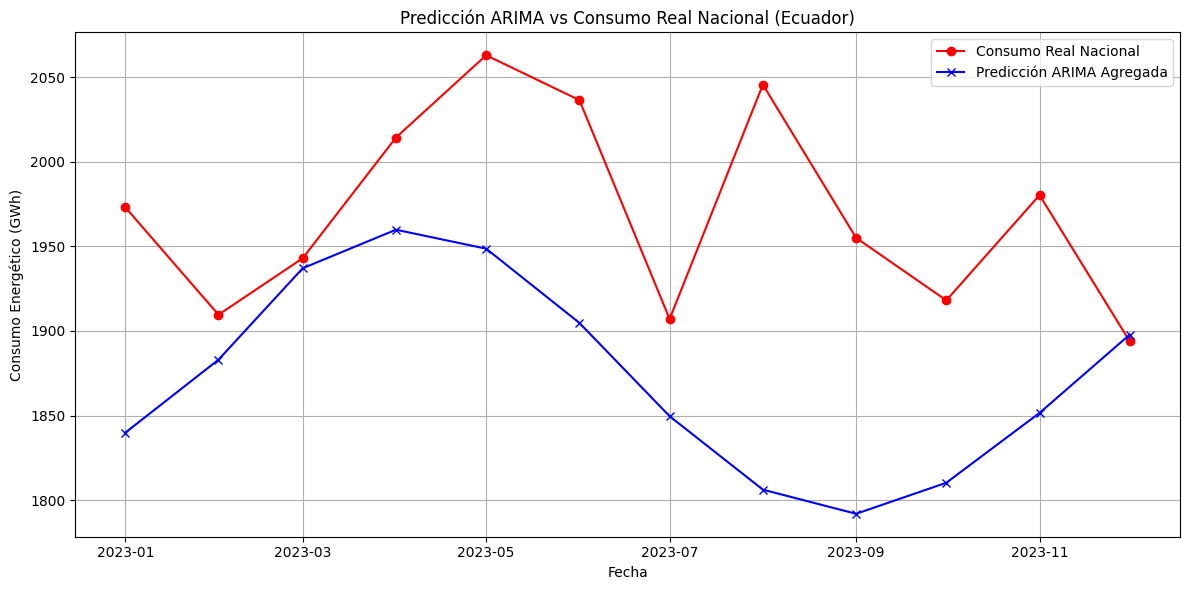

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Real_GWh'], label='Consumo Real Nacional', color='red', marker='o')
plt.plot(df_comparacion['Fecha'], df_comparacion['Prediccion_GWh'], label='Predicción ARIMA Agregada', color='blue', marker='x')
plt.title('Predicción ARIMA vs Consumo Real Nacional (Ecuador)')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético (GWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


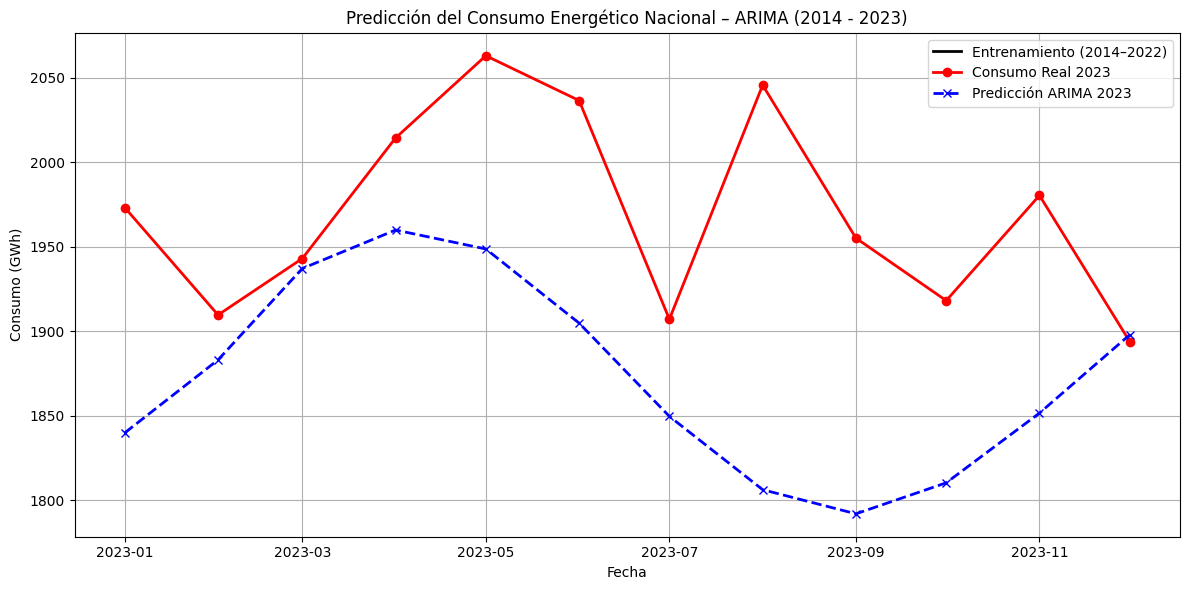

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar que las fechas estén en formato datetime
df_comparacion['Fecha'] = pd.to_datetime(df_comparacion['Fecha'])

# Separar por periodos
entrenamiento = df_comparacion[df_comparacion['Fecha'].dt.year <= 2022]
test_real = df_comparacion[df_comparacion['Fecha'].dt.year == 2023]
test_pred = test_real.dropna(subset=['Prediccion_GWh'])

# === GRÁFICO FINAL ===
plt.figure(figsize=(12, 6))

# Curva real de entrenamiento
plt.plot(entrenamiento['Fecha'], entrenamiento['Real_GWh'],
         label='Entrenamiento (2014–2022)', color='black', linewidth=2)

# Curva real de test (2023)
plt.plot(test_real['Fecha'], test_real['Real_GWh'],
         label='Consumo Real 2023', color='red', marker='o', linewidth=2)

# Predicción ARIMA para 2023
plt.plot(test_pred['Fecha'], test_pred['Prediccion_GWh'],
         label='Predicción ARIMA 2023', color='blue', linestyle='--', marker='x', linewidth=2)

# Título y estética
plt.title('Predicción del Consumo Energético Nacional – ARIMA (2014 - 2023)')
plt.xlabel('Fecha')
plt.ylabel('Consumo (GWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("grafico_arima_2014_2023.png")
plt.show()


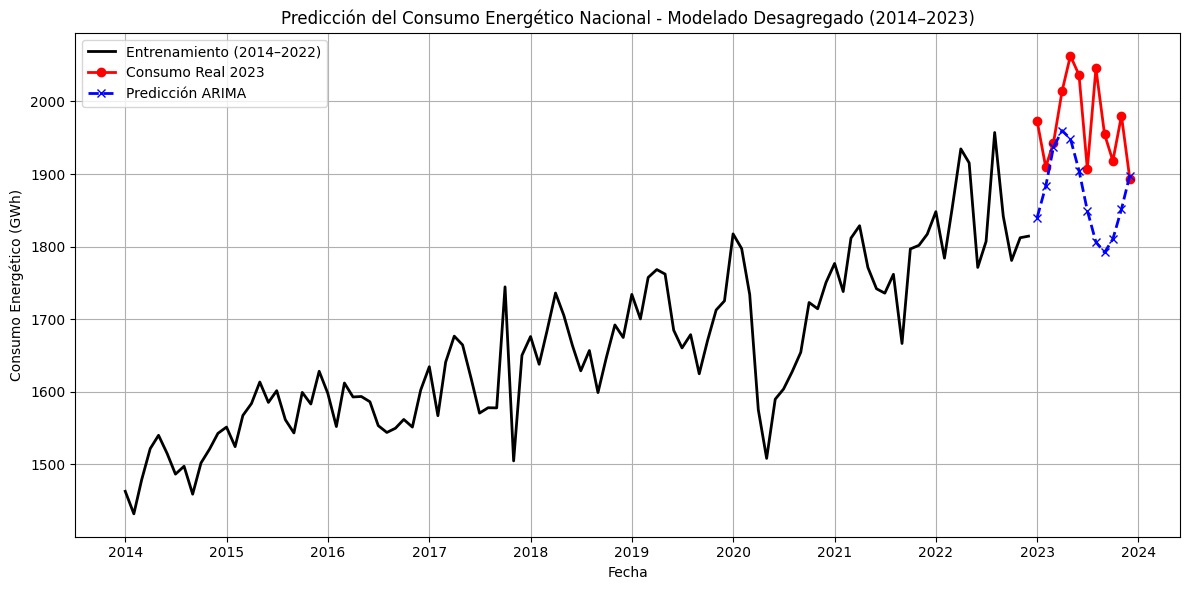

In [ ]:
# Asegurar tener toda la curva real desde 2014
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

#Convertir fechas a datetime si no lo están
df_nacional_predicho["Fecha"] = pd.to_datetime(df_nacional_predicho["Fecha"])
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])

#Unir predicción con la curva real
df_comparacion = pd.merge(df_nacional_real, df_nacional_predicho, on="Fecha", how="left")
df_comparacion.columns = ["Fecha", "Real_GWh", "Prediccion_GWh"]

#Separar fases
df_entrenamiento = df_comparacion[df_comparacion["Fecha"].dt.year < 2023]
df_test_real = df_comparacion[df_comparacion["Fecha"].dt.year == 2023]
df_test_pred = df_test_real.dropna(subset=["Prediccion_GWh"])  # asegurar solo fechas con predicción

#Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_entrenamiento["Fecha"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2022)", color="black", linewidth=2)

plt.plot(df_test_real["Fecha"], df_test_real["Real_GWh"],
         label="Consumo Real 2023", color="red", marker="o", linewidth=2)

plt.plot(df_test_pred["Fecha"], df_test_pred["Prediccion_GWh"],
         label="Predicción ARIMA ", color="blue", linestyle="--", marker="x", linewidth=2)

plt.title("Predicción del Consumo Energético Nacional - Modelado Desagregado (2014–2023)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Filtrar los datos de test: solo 2023
df_test_2023 = df_comparacion[df_comparacion['Fecha'].dt.year == 2023].copy()

# Extraer reales y predichos
y_real = df_test_2023['Real_GWh']
y_pred = df_test_2023['Prediccion_GWh']

# Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mape = np.mean(np.abs((y_real - y_pred) / y_real.replace(0, np.nan))) * 100  # evitar división por cero


# 4. Mostrar resultados
print("📊 MÉTRICAS DE ERROR – ARIMA (2023)")
print("────────────────────────────────────")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")



📊 MÉTRICAS DE ERROR – ARIMA (2023)
────────────────────────────────────
✅ MAE  : 97.25 GWh
✅ RMSE : 118.09 GWh
✅ MAPE : 4.88 %
✅ R²   : -3.4127


2024

In [ ]:
!pip install numpy==1.23.5  # Versión estable compatible
!pip install pmdarima==2.0.3

In [ ]:
import pandas as pd
df_estadistico = pd.read_csv('/content/df_estadistico.csv',
                 encoding='latin-1',
                 sep=',',
                 decimal='.')


In [ ]:
from collections import defaultdict

fechas_completas = pd.date_range(start='2014-01-01', end='2024-12-01', freq='MS')
n_total_meses = len(fechas_completas)

series_dict = {}
series_faltantes = {}
series_descartadas = {}

# Recalcular agrupado limpio
df_agrupado = df_estadistico.groupby(['Fecha', 'Grupo_Consumo', 'Latitud', 'Longitud'])['Energia_GWh'].sum().reset_index()

for key, grupo in df_agrupado.groupby(['Grupo_Consumo', 'Latitud', 'Longitud']):
    serie = grupo[['Fecha', 'Energia_GWh']].copy()
    serie['Fecha'] = pd.to_datetime(serie['Fecha'])
    serie = serie.drop_duplicates(subset='Fecha')
    serie = serie.set_index('Fecha').sort_index()
    serie = serie[~serie.index.duplicated(keep='first')]
    serie = serie.asfreq('MS')
    serie = serie.reindex(fechas_completas)

    # Detectar fechas faltantes originales
    fechas_faltantes = serie[serie['Energia_GWh'].isna()].index
    series_faltantes[key] = fechas_faltantes

    # 🔍 Analizar por año
    faltantes_por_anio = defaultdict(int)
    for fecha in fechas_faltantes:
        faltantes_por_anio[fecha.year] += 1

    # Contar cuántos años tienen > 2 meses faltantes
    años_invalidos = sum(1 for f in faltantes_por_anio.values() if f > 2)

    if años_invalidos > 2:
        series_descartadas[key] = fechas_faltantes
        continue  # ❌ Descartar esta serie

    # ✅ Mantener: interpolar
    serie = serie.interpolate(method='linear')
    serie = serie.fillna(0)
    series_dict[key] = serie

In [ ]:
print(f"🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: {len(series_descartadas)}")
for i, (clave, fechas) in enumerate(series_descartadas.items()):
    grupo, lat, lon = clave
    print(f"{i+1}. {grupo} - ({lat}, {lon}) → {len(fechas)} fechas faltantes")
    if i >= 4: break


🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: 1
1. Alumbrado PÃºblico - (0.5022, -77.8857) → 71 fechas faltantes


In [ ]:
n_total_series = len(series_dict) + len(series_descartadas)

print("📊 RESUMEN DE PROCESAMIENTO DE SERIES")
print("──────────────────────────────────────────")
print(f"🔢 Total de series analizadas:     {n_total_series}")
print(f"✅ Series conservadas (interpoladas): {len(series_dict)}")
print(f"❌ Series descartadas (>2 años incompletos): {len(series_descartadas)}")
print("──────────────────────────────────────────")


📊 RESUMEN DE PROCESAMIENTO DE SERIES
──────────────────────────────────────────
🔢 Total de series analizadas:     116
✅ Series conservadas (interpoladas): 115
❌ Series descartadas (>2 años incompletos): 1
──────────────────────────────────────────


In [ ]:
from pmdarima import auto_arima

def obtener_parametros_arima(serie):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    y = serie['Energia_GWh']

    modelo = auto_arima(y,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore")

    orden = modelo.order
    print(f"→ ARIMA{orden}")
    return orden


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

parametros_por_serie = {}

for clave, serie in series_dict.items():

    try:
        print(f"📈 Analizando {clave}")
        orden = obtener_parametros_arima(serie)
        parametros_por_serie[clave] = orden
    except Exception as e:
        print(f"❌ Error en {clave}: {e}")

📈 Analizando ('Alumbrado PÃºblico', -3.9931, -79.2042)
→ ARIMA(1, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -3.2596, -79.9585)
→ ARIMA(0, 1, 3)
📈 Analizando ('Alumbrado PÃºblico', -2.9006, -79.0045)
→ ARIMA(2, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -2.5489, -78.9382)
→ ARIMA(1, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -2.2301, -80.8599)
→ ARIMA(3, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -2.1709, -79.9224)
→ ARIMA(0, 1, 2)
📈 Analizando ('Alumbrado PÃºblico', -1.7946, -79.5342)
→ ARIMA(1, 0, 2)
📈 Analizando ('Alumbrado PÃºblico', -1.6708, -78.6569)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -1.6167, -79.0)
→ ARIMA(1, 1, 0)
📈 Analizando ('Alumbrado PÃºblico', -1.2543, -78.622)
→ ARIMA(3, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.9676, -80.7089)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.9538, -90.9656)
→ ARIMA(1, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.9381, -78.614)
→ ARIMA(0, 1, 1)
📈 Analizando ('Alumbrado PÃºblico', -0.6743, -76.9864)
→ ARIMA(0, 1, 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def ajustar_y_predecir_arima(serie, orden):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    # Cortar por fecha explícita
    train = serie.loc[:'2023-12-01']
    test = serie.loc['2024-01-01':'2024-12-01']

    modelo = ARIMA(train, order=orden)
    resultado = modelo.fit()

    pred = resultado.forecast(steps=len(test))
    fechas = test.index

    df_pred = pd.DataFrame({
        'Fecha': fechas,
        'Prediccion_GWh': pred.values,
        'Real_GWh': test['Energia_GWh'].values
    })

    # Métricas
    denominador = test['Energia_GWh'].replace(0, np.nan)
    mae = mean_absolute_error(test['Energia_GWh'], pred)
    rmse = np.sqrt(mean_squared_error(test['Energia_GWh'], pred))
    mape = np.mean(np.abs((test['Energia_GWh'] - pred) / denominador)) * 100

    print(f"ARIMA{orden} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")
    return df_pred

In [ ]:
todas_las_predicciones = []
warnings.filterwarnings("ignore", category=FutureWarning)
for clave, serie in series_dict.items():
    if clave in parametros_por_serie:
        orden = parametros_por_serie[clave]
        grupo, lat, lon = clave
        try:
            print(f"🔁 Procesando {grupo} - ({lat}, {lon}) con ARIMA{orden}")
            df_pred = ajustar_y_predecir_arima(serie, orden=orden)
            df_pred['Grupo_Consumo'] = grupo
            df_pred['Latitud'] = lat
            df_pred['Longitud'] = lon
            todas_las_predicciones.append(df_pred)
        except Exception as e:
            print(f"❌ Error en {clave}: {e}")

if 'todas_las_predicciones' in locals():
    df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)
else:
    print("❌ La variable 'todas_las_predicciones' no está definida.")

🔁 Procesando Alumbrado PÃºblico - (-3.9931, -79.2042) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.3532 | RMSE: 0.5285 | MAPE: 7.96%
🔁 Procesando Alumbrado PÃºblico - (-3.2596, -79.9585) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 3.4188 | RMSE: 3.5130 | MAPE: 40.83%
🔁 Procesando Alumbrado PÃºblico - (-2.9006, -79.0045) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 0.3965 | RMSE: 0.4654 | MAPE: 3.20%
🔁 Procesando Alumbrado PÃºblico - (-2.5489, -78.9382) con ARIMA(1, 1, 2)
ARIMA(1, 1, 2) | MAE: 0.0519 | RMSE: 0.0647 | MAPE: 4.05%
🔁 Procesando Alumbrado PÃºblico - (-2.2301, -80.8599) con ARIMA(3, 1, 1)
ARIMA(3, 1, 1) | MAE: 1.5657 | RMSE: 2.7993 | MAPE: 313.24%
🔁 Procesando Alumbrado PÃºblico - (-2.1709, -79.9224) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 2.9147 | RMSE: 5.6177 | MAPE: 9.78%
🔁 Procesando Alumbrado PÃºblico - (-1.7946, -79.5342) con ARIMA(1, 0, 2)
ARIMA(1, 0, 2) | MAE: 0.6646 | RMSE: 1.0223 | MAPE: 323.34%
🔁 Procesando Alumbrado PÃºblico - (-1.6708, -78.6569) con ARIMA(0, 1, 1)
ARIMA

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) | MAE: 0.0771 | RMSE: 0.1194 | MAPE: 4.38%
🔁 Procesando Comercial - (0.9682, -79.6517) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.4766 | RMSE: 0.6510 | MAPE: 9.78%
🔁 Procesando Industrial - (-4.0655, -78.9542) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 18.2046 | RMSE: 19.7892 | MAPE: 57.58%
🔁 Procesando Industrial - (-3.9931, -79.2042) con ARIMA(2, 1, 3)
ARIMA(2, 1, 3) | MAE: 0.1026 | RMSE: 0.1260 | MAPE: 11.49%
🔁 Procesando Industrial - (-3.2596, -79.9585) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 1.7409 | RMSE: 2.3742 | MAPE: 8.34%
🔁 Procesando Industrial - (-2.9006, -79.0045) con ARIMA(1, 0, 0)
ARIMA(1, 0, 0) | MAE: 2.5093 | RMSE: 3.3578 | MAPE: 9.11%
🔁 Procesando Industrial - (-2.5489, -78.9382) con ARIMA(1, 1, 0)
ARIMA(1, 1, 0) | MAE: 0.4667 | RMSE: 0.5675 | MAPE: 11.33%
🔁 Procesando Industrial - (-2.393, -78.1105) con ARIMA(1, 0, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) | MAE: 0.0413 | RMSE: 0.0453 | MAPE: 19.93%
🔁 Procesando Industrial - (-2.2301, -80.8599) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.8506 | RMSE: 1.1880 | MAPE: 16.35%
🔁 Procesando Industrial - (-2.1709, -79.9224) con ARIMA(2, 1, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) | MAE: 16.5514 | RMSE: 20.9781 | MAPE: 8.82%
🔁 Procesando Industrial - (-1.7946, -79.5342) con ARIMA(0, 0, 2)
ARIMA(0, 0, 2) | MAE: 1.1786 | RMSE: 1.6297 | MAPE: 22.33%
🔁 Procesando Industrial - (-1.6708, -78.6569) con ARIMA(1, 0, 1)
ARIMA(1, 0, 1) | MAE: 4.0114 | RMSE: 5.1509 | MAPE: 104.89%
🔁 Procesando Industrial - (-1.6167, -79.0) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.0037 | RMSE: 0.0046 | MAPE: 6.08%
🔁 Procesando Industrial - (-1.491, -77.9916) con ARIMA(2, 1, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) | MAE: 0.0257 | RMSE: 0.0298 | MAPE: 5.86%
🔁 Procesando Industrial - (-1.2543, -78.622) con ARIMA(1, 0, 0)
ARIMA(1, 0, 0) | MAE: 0.5741 | RMSE: 0.7137 | MAPE: 6.33%
🔁 Procesando Industrial - (-1.0515, -77.732) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.1509 | RMSE: 0.2208 | MAPE: 10.56%
🔁 Procesando Industrial - (-0.9676, -80.7089) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 4.2767 | RMSE: 7.4094 | MAPE: 125.54%
🔁 Procesando Industrial - (-0.9538, -90.9656) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 0.0071 | RMSE: 0.0086 | MAPE: 11.66%
🔁 Procesando Industrial - (-0.9381, -78.614) con ARIMA(0, 0, 2)
ARIMA(0, 0, 2) | MAE: 2.9856 | RMSE: 3.4747 | MAPE: 15.79%
🔁 Procesando Industrial - (-0.6743, -76.9864) con ARIMA(1, 0, 1)
ARIMA(1, 0, 1) | MAE: 0.1866 | RMSE: 0.1987 | MAPE: 12.14%
🔁 Procesando Industrial - (-0.2511, -79.1717) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.5522 | RMSE: 0.8433 | MAPE: 11.68%
🔁 Procesando Industrial - (-0.2295, -78.5243) con ARIMA(0, 1, 2)
ARIMA(0, 1, 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) | MAE: 4.8773 | RMSE: 5.7157 | MAPE: 16.21%
🔁 Procesando Otros - (0.087, -76.8881) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.3613 | RMSE: 0.7760 | MAPE: 2487.88%
🔁 Procesando Otros - (0.3517, -78.1223) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.2338 | RMSE: 0.2792 | MAPE: 8.57%
🔁 Procesando Otros - (0.5022, -77.8857) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 0.0269 | RMSE: 0.0439 | MAPE: 4.85%
🔁 Procesando Otros - (0.9682, -79.6517) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.5946 | RMSE: 0.7822 | MAPE: 8.43%
🔁 Procesando Residencial - (-4.0655, -78.9542) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 0.2703 | RMSE: 0.3086 | MAPE: 8.65%
🔁 Procesando Residencial - (-3.9931, -79.2042) con ARIMA(0, 1, 2)
ARIMA(0, 1, 2) | MAE: 0.9329 | RMSE: 1.3677 | MAPE: 7.45%
🔁 Procesando Residencial - (-3.2596, -79.9585) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 5.5629 | RMSE: 6.3883 | MAPE: 16.66%
🔁 Procesando Residencial - (-2.9006, -79.0045) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 1.7209 | R

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 2) | MAE: 1.1197 | RMSE: 1.6262 | MAPE: 7.04%
🔁 Procesando Residencial - (-1.0515, -77.732) con ARIMA(1, 1, 2)
ARIMA(1, 1, 2) | MAE: 0.1499 | RMSE: 0.1785 | MAPE: 4.23%
🔁 Procesando Residencial - (-0.9676, -80.7089) con ARIMA(2, 1, 1)
ARIMA(2, 1, 1) | MAE: 15.4805 | RMSE: 22.6274 | MAPE: 79.79%
🔁 Procesando Residencial - (-0.9538, -90.9656) con ARIMA(0, 1, 0)
ARIMA(0, 1, 0) | MAE: 0.4697 | RMSE: 0.5837 | MAPE: 17.05%
🔁 Procesando Residencial - (-0.9381, -78.614) con ARIMA(1, 1, 1)
ARIMA(1, 1, 1) | MAE: 0.8739 | RMSE: 1.0818 | MAPE: 8.67%
🔁 Procesando Residencial - (-0.6743, -76.9864) con ARIMA(0, 1, 3)
ARIMA(0, 1, 3) | MAE: 0.2855 | RMSE: 0.3611 | MAPE: 4.45%
🔁 Procesando Residencial - (-0.2511, -79.1717) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 1.2499 | RMSE: 1.9468 | MAPE: 8.05%
🔁 Procesando Residencial - (-0.2295, -78.5243) con ARIMA(0, 1, 1)
ARIMA(0, 1, 1) | MAE: 7.2150 | RMSE: 10.1959 | MAPE: 5.57%
🔁 Procesando Residencial - (0.087, -76.8881) con ARIMA(1, 1, 1)
ARIMA(1

In [ ]:
df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)

# Sumar todas las predicciones mensuales para obtener la curva nacional
df_nacional_predicho = df_total_pred.groupby('Fecha')['Prediccion_GWh'].sum().reset_index()


In [ ]:
# Calcular la curva nacional real (suma de todas las series por mes)
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

In [ ]:
# Asegurar tipo datetime para ambas columnas 'Fecha'
df_nacional_predicho['Fecha'] = pd.to_datetime(df_nacional_predicho['Fecha'])
df_nacional_real['Fecha'] = pd.to_datetime(df_nacional_real['Fecha'])

# Ahora sí: unir ambas curvas
df_comparacion = pd.merge(df_nacional_predicho, df_nacional_real, on='Fecha', how='inner')
df_comparacion.columns = ['Fecha', 'Prediccion_GWh', 'Real_GWh']

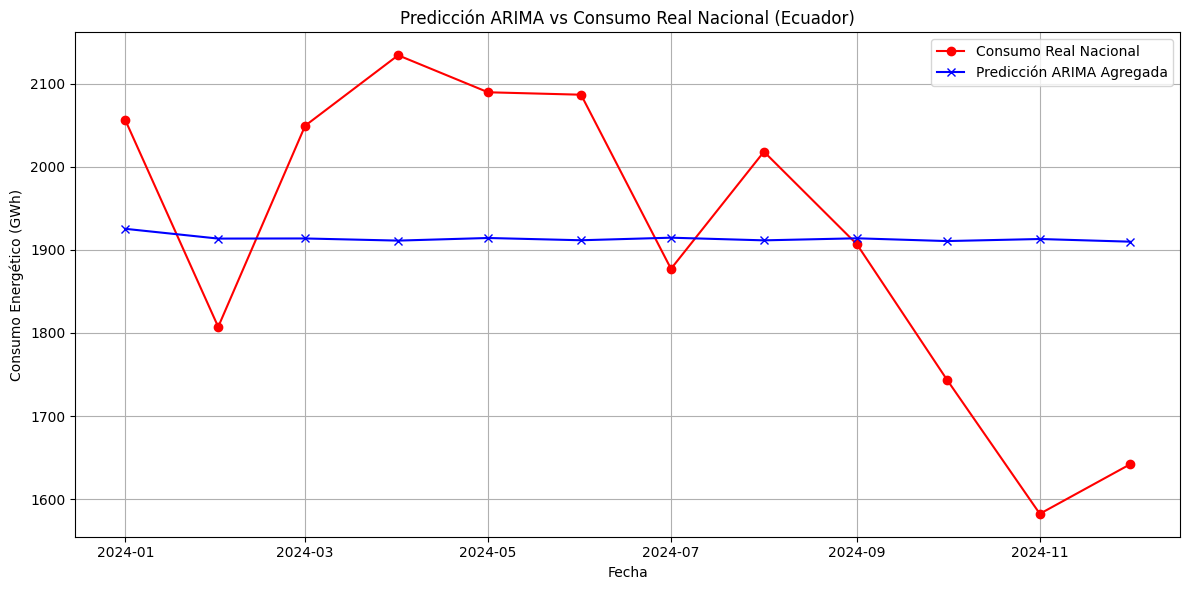

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Real_GWh'], label='Consumo Real Nacional', color='red', marker='o')
plt.plot(df_comparacion['Fecha'], df_comparacion['Prediccion_GWh'], label='Predicción ARIMA Agregada', color='blue', marker='x')
plt.title('Predicción ARIMA vs Consumo Real Nacional (Ecuador)')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético (GWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


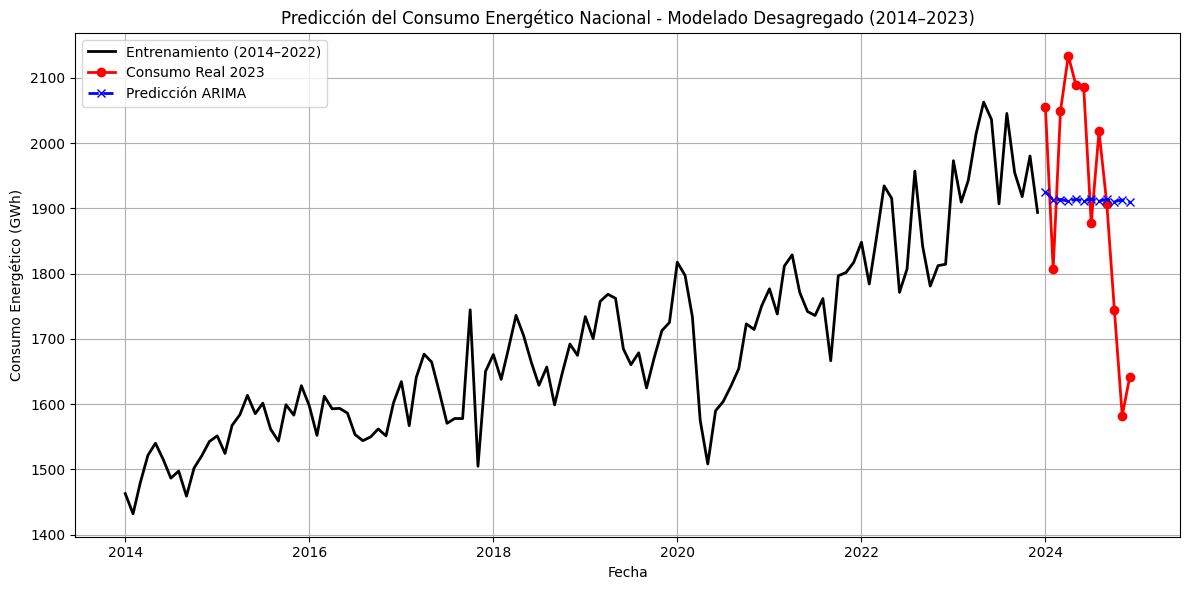

In [ ]:
# Asegurar  tener toda la curva real desde 2014
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

# Convertir fechas a datetime si no lo están
df_nacional_predicho["Fecha"] = pd.to_datetime(df_nacional_predicho["Fecha"])
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])

# Unir predicción con la curva real
df_comparacion = pd.merge(df_nacional_real, df_nacional_predicho, on="Fecha", how="left")
df_comparacion.columns = ["Fecha", "Real_GWh", "Prediccion_GWh"]

# Separar fases
df_entrenamiento = df_comparacion[df_comparacion["Fecha"].dt.year < 2024]
df_test_real = df_comparacion[df_comparacion["Fecha"].dt.year == 2024]
df_test_pred = df_test_real.dropna(subset=["Prediccion_GWh"])  # asegurar solo fechas con predicción

# Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_entrenamiento["Fecha"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2023)", color="black", linewidth=2)

plt.plot(df_test_real["Fecha"], df_test_real["Real_GWh"],
         label="Consumo Real 2024", color="red", marker="o", linewidth=2)

plt.plot(df_test_pred["Fecha"], df_test_pred["Prediccion_GWh"],
         label="Predicción ARIMA ", color="blue", linestyle="--", marker="x", linewidth=2)

plt.title("Predicción del Consumo Energético Nacional - Modelado Desagregado (2014–2024)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Filtrar los datos de test: solo 2024
df_test_2023 = df_comparacion[df_comparacion['Fecha'].dt.year == 2024].copy()

# Extraer reales y predichos
y_real = df_test_2023['Real_GWh']
y_pred = df_test_2023['Prediccion_GWh']

# Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mape = np.mean(np.abs((y_real - y_pred) / y_real.replace(0, np.nan))) * 100  # evitar división por cero


# Mostrar resultados
print("📊 MÉTRICAS DE ERROR – ARIMA (2023)")
print("────────────────────────────────────")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")



📊 MÉTRICAS DE ERROR – ARIMA (2023)
────────────────────────────────────
✅ MAE  : 155.22 GWh
✅ RMSE : 177.86 GWh
✅ MAPE : 8.38 %
✅ R²   : 0.0116


# SARIMA

In [ ]:
!pip install numpy==1.23.5  # Versión estable compatible
!pip install pmdarima==2.0.3

In [ ]:
import pandas as pd
df_estadistico = pd.read_csv('/content/df_estadistico.csv',
                 encoding='latin-1',
                 sep=',',
                 decimal='.')



In [ ]:
from collections import defaultdict

fechas_completas = pd.date_range(start='2014-01-01', end='2023-12-01', freq='MS')
n_total_meses = len(fechas_completas)

series_dict = {}
series_faltantes = {}
series_descartadas = {}

# Recalcular agrupado limpio
df_agrupado = df_estadistico.groupby(['Fecha', 'Grupo_Consumo', 'Latitud', 'Longitud'])['Energia_GWh'].sum().reset_index()

for key, grupo in df_agrupado.groupby(['Grupo_Consumo', 'Latitud', 'Longitud']):
    serie = grupo[['Fecha', 'Energia_GWh']].copy()
    serie['Fecha'] = pd.to_datetime(serie['Fecha'])
    serie = serie.drop_duplicates(subset='Fecha')
    serie = serie.set_index('Fecha').sort_index()
    serie = serie[~serie.index.duplicated(keep='first')]
    serie = serie.asfreq('MS')
    serie = serie.reindex(fechas_completas)

    # Detectar fechas faltantes originales
    fechas_faltantes = serie[serie['Energia_GWh'].isna()].index
    series_faltantes[key] = fechas_faltantes

    # 🔍 Analizar por año
    faltantes_por_anio = defaultdict(int)
    for fecha in fechas_faltantes:
        faltantes_por_anio[fecha.year] += 1

    # Contar cuántos años tienen > 2 meses faltantes
    años_invalidos = sum(1 for f in faltantes_por_anio.values() if f > 2)

    if años_invalidos > 2:
        series_descartadas[key] = fechas_faltantes
        continue  # ❌ Descartar esta serie

    # ✅ Mantener: interpolar
    serie = serie.interpolate(method='linear')
    serie = serie.fillna(0)
    series_dict[key] = serie

In [ ]:
print(f"🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: {len(series_descartadas)}")
for i, (clave, fechas) in enumerate(series_descartadas.items()):
    grupo, lat, lon = clave
    print(f"{i+1}. {grupo} - ({lat}, {lon}) → {len(fechas)} fechas faltantes")
    if i >= 4: break


🚫 Series descartadas por tener >2 años con más del 20 % de valores faltantes: 1
1. Alumbrado PÃºblico - (0.5022, -77.8857) → 59 fechas faltantes


In [ ]:
n_total_series = len(series_dict) + len(series_descartadas)

print("📊 RESUMEN DE PROCESAMIENTO DE SERIES")
print("──────────────────────────────────────────")
print(f"🔢 Total de series analizadas:     {n_total_series}")
print(f"✅ Series conservadas (interpoladas): {len(series_dict)}")
print(f"❌ Series descartadas (>2 años incompletos): {len(series_descartadas)}")
print("──────────────────────────────────────────")


📊 RESUMEN DE PROCESAMIENTO DE SERIES
──────────────────────────────────────────
🔢 Total de series analizadas:     116
✅ Series conservadas (interpoladas): 115
❌ Series descartadas (>2 años incompletos): 1
──────────────────────────────────────────


In [ ]:
from pmdarima import auto_arima

def obtener_parametros_sarima(serie):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()
    y = serie['Energia_GWh']

    modelo = auto_arima(y,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        d=None,
                        seasonal=True,     # ⭐ Activamos SARIMA
                        m=12,              # ⭐ Periodo estacional mensual
                        start_P=0, start_Q=0,
                        max_P=2, max_Q=2,
                        D=None,
                        trace=True,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore")

    orden = modelo.order          # (p, d, q)
    orden_seasonal = modelo.seasonal_order  # (P, D, Q, s)
    print(f"→ SARIMA{orden} x {orden_seasonal}")
    return orden, orden_seasonal


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

parametros_por_serie = {}

for clave, serie in series_dict.items():
    try:
        print(f"📈 Analizando {clave}")
        orden, orden_seasonal = obtener_parametros_sarima(serie)
        parametros_por_serie[clave] = (orden, orden_seasonal)
    except Exception as e:
        print(f"❌ Error en {clave}: {e}")


📈 Analizando ('Alumbrado PÃºblico', -3.9931, -79.2042)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-11.170, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-71.498, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-94.376, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-12.822, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-91.677, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-95.399, Time=0.77 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-95.430, Time=0.42 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-94.898, Time=1.33 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-91.732, Time=1.42 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-19.881, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-96.179, Time=2.84 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-93.959, Time=0.49 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-96.319, Time=1.18 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


def ajustar_y_predecir_sarima(serie, orden, orden_seasonal):
    serie = serie.sort_index().asfreq('MS')
    serie = serie.interpolate()

    train = serie.loc[:'2022-12-01']
    test = serie.loc['2023-01-01':'2023-12-01']

    modelo = SARIMAX(train,
                     order=orden,
                     seasonal_order=orden_seasonal,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

    resultado = modelo.fit(disp=False)
    pred = resultado.forecast(steps=len(test))

    fechas = test.index
    df_pred = pd.DataFrame({
        'Fecha': fechas,
        'Prediccion_GWh': pred.values,
        'Real_GWh': test['Energia_GWh'].values
    })

    # Métricas
    denominador = test['Energia_GWh'].replace(0, np.nan)
    mae = mean_absolute_error(test['Energia_GWh'], pred)
    rmse = np.sqrt(mean_squared_error(test['Energia_GWh'], pred))
    mape = np.mean(np.abs((test['Energia_GWh'] - pred) / denominador)) * 100

    print(f"SARIMA{orden} x {orden_seasonal} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
    return df_pred


In [ ]:
import numpy as np

todas_las_predicciones = []
warnings.filterwarnings("ignore", category=FutureWarning)

for clave, serie in series_dict.items():
    if clave in parametros_por_serie:
        orden, orden_seasonal = parametros_por_serie[clave]
        grupo, lat, lon = clave
        try:
            print(f"🔁 Procesando {grupo} - ({lat}, {lon}) con SARIMA{orden} x {orden_seasonal}")
            df_pred = ajustar_y_predecir_sarima(serie, orden=orden, orden_seasonal=orden_seasonal)
            df_pred['Grupo_Consumo'] = grupo
            df_pred['Latitud'] = lat
            df_pred['Longitud'] = lon
            todas_las_predicciones.append(df_pred)
        except Exception as e:
            print(f"❌ Error en {clave}: {e}")


🔁 Procesando Alumbrado PÃºblico - (-3.9931, -79.2042) con SARIMA(1, 1, 1) x (1, 0, 1, 12)
SARIMA(1, 1, 1) x (1, 0, 1, 12) | MAE: 0.24 | RMSE: 0.30 | MAPE: 5.46%
🔁 Procesando Alumbrado PÃºblico - (-3.2596, -79.9585) con SARIMA(0, 0, 2) x (0, 1, 0, 12)
SARIMA(0, 0, 2) x (0, 1, 0, 12) | MAE: 9.26 | RMSE: 18.04 | MAPE: 28.21%
🔁 Procesando Alumbrado PÃºblico - (-2.9006, -79.0045) con SARIMA(1, 1, 1) x (1, 0, 1, 12)
SARIMA(1, 1, 1) x (1, 0, 1, 12) | MAE: 0.12 | RMSE: 0.13 | MAPE: 1.02%
🔁 Procesando Alumbrado PÃºblico - (-2.5489, -78.9382) con SARIMA(1, 1, 2) x (0, 0, 0, 12)
SARIMA(1, 1, 2) x (0, 0, 0, 12) | MAE: 0.03 | RMSE: 0.04 | MAPE: 2.58%
🔁 Procesando Alumbrado PÃºblico - (-2.2301, -80.8599) con SARIMA(0, 1, 1) x (0, 0, 0, 12)
SARIMA(0, 1, 1) x (0, 0, 0, 12) | MAE: 0.47 | RMSE: 0.96 | MAPE: 6.23%
🔁 Procesando Alumbrado PÃºblico - (-2.1709, -79.9224) con SARIMA(0, 1, 1) x (0, 0, 2, 12)
SARIMA(0, 1, 1) x (0, 0, 2, 12) | MAE: 0.90 | RMSE: 1.33 | MAPE: 3.34%
🔁 Procesando Alumbrado PÃºblico 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1) x (1, 0, 0, 12) | MAE: 0.06 | RMSE: 0.07 | MAPE: 4.19%
🔁 Procesando Comercial - (-1.491, -77.9916) con SARIMA(0, 1, 2) x (0, 0, 0, 12)
SARIMA(0, 1, 2) x (0, 0, 0, 12) | MAE: 0.09 | RMSE: 0.12 | MAPE: 5.85%
🔁 Procesando Comercial - (-1.2543, -78.622) con SARIMA(0, 1, 2) x (0, 0, 0, 12)
SARIMA(0, 1, 2) x (0, 0, 0, 12) | MAE: 0.27 | RMSE: 0.42 | MAPE: 3.44%
🔁 Procesando Comercial - (-1.0515, -77.732) con SARIMA(1, 1, 1) x (0, 0, 0, 12)
SARIMA(1, 1, 1) x (0, 0, 0, 12) | MAE: 0.19 | RMSE: 0.21 | MAPE: 10.41%
🔁 Procesando Comercial - (-0.9676, -80.7089) con SARIMA(0, 1, 0) x (1, 0, 1, 12)
SARIMA(0, 1, 0) x (1, 0, 1, 12) | MAE: 3.98 | RMSE: 4.17 | MAPE: 13.53%
🔁 Procesando Comercial - (-0.9538, -90.9656) con SARIMA(0, 1, 0) x (1, 0, 1, 12)
SARIMA(0, 1, 0) x (1, 0, 1, 12) | MAE: 0.61 | RMSE: 0.67 | MAPE: 24.11%
🔁 Procesando Comercial - (-0.9381, -78.614) con SARIMA(1, 1, 1) x (0, 0, 0, 12)
SARIMA(1, 1, 1) x (0, 0, 0, 12) | MAE: 0.39 | RMSE: 0.54 | MAPE: 9.65%
🔁 Procesando Comer

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🔁 Procesando Comercial - (-0.2511, -79.1717) con SARIMA(0, 1, 1) x (1, 0, 0, 12)
SARIMA(0, 1, 1) x (1, 0, 0, 12) | MAE: 0.98 | RMSE: 1.13 | MAPE: 7.51%
🔁 Procesando Comercial - (-0.2295, -78.5243) con SARIMA(3, 0, 0) x (0, 0, 0, 12)
SARIMA(3, 0, 0) x (0, 0, 0, 12) | MAE: 2.78 | RMSE: 3.15 | MAPE: 3.50%
🔁 Procesando Comercial - (0.087, -76.8881) con SARIMA(2, 0, 0) x (0, 0, 0, 12)
SARIMA(2, 0, 0) x (0, 0, 0, 12) | MAE: 0.29 | RMSE: 0.38 | MAPE: 7.40%
🔁 Procesando Comercial - (0.3517, -78.1223) con SARIMA(1, 1, 1) x (0, 0, 0, 12)
SARIMA(1, 1, 1) x (0, 0, 0, 12) | MAE: 0.62 | RMSE: 0.68 | MAPE: 10.21%
🔁 Procesando Comercial - (0.5022, -77.8857) con SARIMA(1, 1, 2) x (0, 0, 0, 12)
SARIMA(1, 1, 2) x (0, 0, 0, 12) | MAE: 0.12 | RMSE: 0.12 | MAPE: 6.00%
🔁 Procesando Comercial - (0.9682, -79.6517) con SARIMA(0, 1, 1) x (0, 0, 0, 12)
SARIMA(0, 1, 1) x (0, 0, 0, 12) | MAE: 0.32 | RMSE: 0.38 | MAPE: 5.54%
🔁 Procesando Industrial - (-4.0655, -78.9542) con SARIMA(1, 1, 1) x (0, 0, 0, 12)
SARIMA(1, 

In [ ]:
print(f"✅ Total de subseries procesadas exitosamente: {len(todas_las_predicciones)}")


✅ Total de subseries procesadas exitosamente: 115


In [ ]:
df_total_pred = pd.concat(todas_las_predicciones, ignore_index=True)

# Sumar todas las predicciones mensuales para obtener la curva nacional
df_nacional_predicho = df_total_pred.groupby('Fecha')['Prediccion_GWh'].sum().reset_index()


In [ ]:
# Calcular la curva nacional real (suma de todas las series por mes)
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

In [ ]:
# Asegurar tipo datetime para ambas columnas 'Fecha'
df_nacional_predicho['Fecha'] = pd.to_datetime(df_nacional_predicho['Fecha'])
df_nacional_real['Fecha'] = pd.to_datetime(df_nacional_real['Fecha'])

# Ahora sí: unir ambas curvas
df_comparacion = pd.merge(df_nacional_predicho, df_nacional_real, on='Fecha', how='inner')
df_comparacion.columns = ['Fecha', 'Prediccion_GWh', 'Real_GWh']

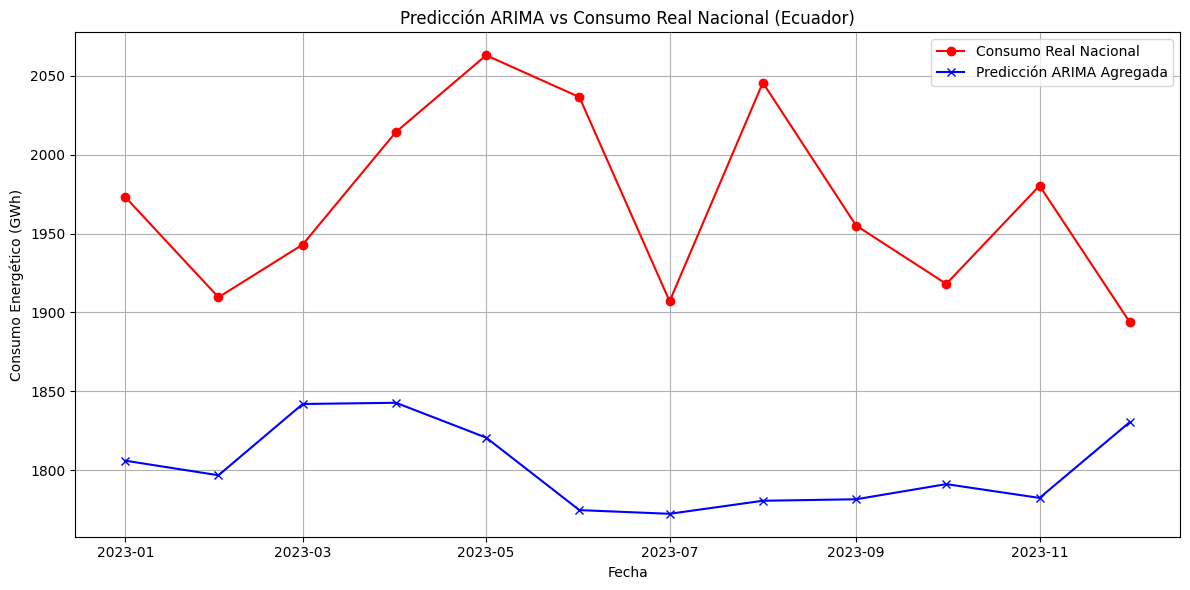

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Real_GWh'], label='Consumo Real Nacional', color='red', marker='o')
plt.plot(df_comparacion['Fecha'], df_comparacion['Prediccion_GWh'], label='Predicción ARIMA Agregada', color='blue', marker='x')
plt.title('Predicción ARIMA vs Consumo Real Nacional (Ecuador)')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético (GWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


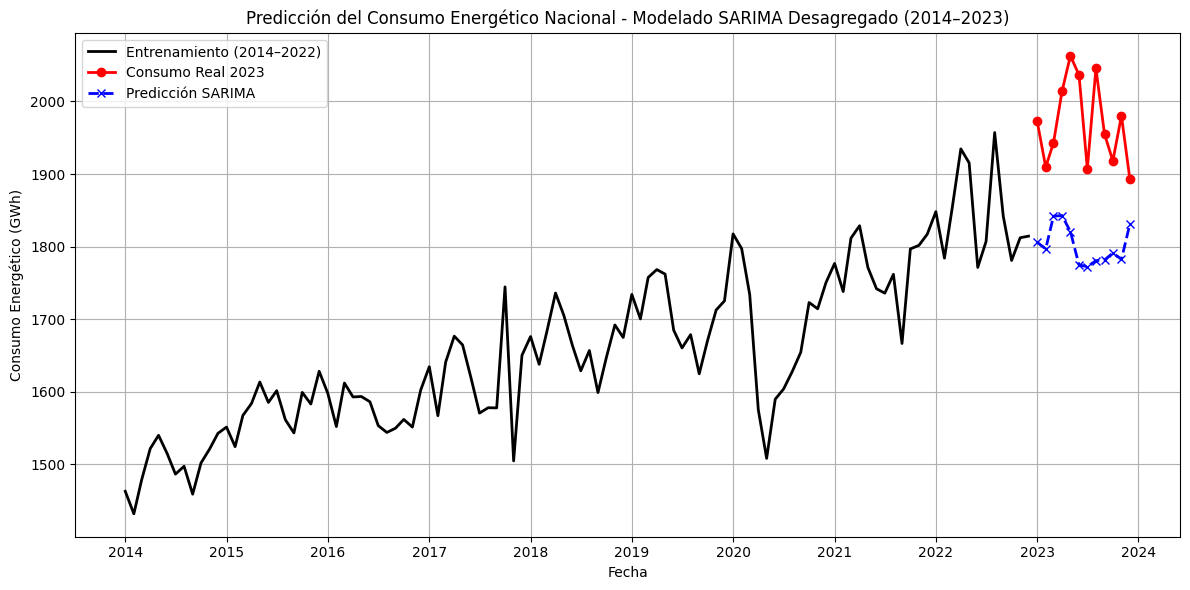

In [ ]:
# 1. Asegúrate de tener toda la curva real desde 2014
df_nacional_real = df_estadistico.copy()
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])
df_nacional_real = df_nacional_real.groupby("Fecha")["Energia_GWh"].sum().reset_index()

# 2. Convertir fechas a datetime si no lo están
df_nacional_predicho["Fecha"] = pd.to_datetime(df_nacional_predicho["Fecha"])
df_nacional_real["Fecha"] = pd.to_datetime(df_nacional_real["Fecha"])

# 3. Unir predicción con la curva real
df_comparacion = pd.merge(df_nacional_real, df_nacional_predicho, on="Fecha", how="left")
df_comparacion.columns = ["Fecha", "Real_GWh", "Prediccion_GWh"]

# 4. Separar fases
df_entrenamiento = df_comparacion[df_comparacion["Fecha"].dt.year < 2023]
df_test_real = df_comparacion[df_comparacion["Fecha"].dt.year == 2023]
df_test_pred = df_test_real.dropna(subset=["Prediccion_GWh"])  # asegurar solo fechas con predicción

# 5. Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_entrenamiento["Fecha"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2022)", color="black", linewidth=2)

plt.plot(df_test_real["Fecha"], df_test_real["Real_GWh"],
         label="Consumo Real 2023", color="red", marker="o", linewidth=2)

plt.plot(df_test_pred["Fecha"], df_test_pred["Prediccion_GWh"],
         label="Predicción SARIMA ", color="blue", linestyle="--", marker="x", linewidth=2)

plt.title("Predicción del Consumo Energético Nacional - Modelado SARIMA Desagregado (2014–2023)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Filtrar los datos de test: solo 2023
df_test_2023 = df_comparacion[df_comparacion['Fecha'].dt.year == 2023].copy()

# 2. Extraer reales y predichos
y_real = df_test_2023['Real_GWh']
y_pred = df_test_2023['Prediccion_GWh']

# 3. Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mape = np.mean(np.abs((y_real - y_pred) / y_real.replace(0, np.nan))) * 100  # evitar división por cero
r2 = r2_score(y_real, y_pred)

# 4. Mostrar resultados
print("📊 MÉTRICAS DE ERROR – ARIMA (2023)")
print("────────────────────────────────────")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")
print(f"✅ R²   : {r2:.4f}")


📊 MÉTRICAS DE ERROR – ARIMA (2023)
────────────────────────────────────
✅ MAE  : 168.15 GWh
✅ RMSE : 179.17 GWh
✅ MAPE : 8.46 %
✅ R²   : -9.1580
